In [7]:
# Import libraries
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, Model
from keras.layers import (Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Dropout, Dense, Flatten)
from keras.callbacks import EarlyStopping

In [8]:
# ImageMaskClassifier
train_image_mask = {'images': [], 'masks': []}
test_image_mask = {'images': [], 'masks': []}

train_image_class = {'images': [], 'labels': []}
test_image_class = {'images': [], 'labels': []}

def load_image_mask(train_image_mask, test_image_mask, image_path, shape=256):
    file_names = os.listdir(image_path)
    partial_names = list(set(fn.split(')')[0] for fn in file_names))
    image_names = [name + ').png' for name in partial_names]
    mask_names = [name + ')_mask.png' for name in partial_names]
    
    train_test_split_index = int(len(image_names) * 0.8)
    
    for i, (image_name, mask_name) in enumerate(zip(image_names, mask_names)):
        image = cv2.resize(plt.imread(os.path.join(image_path, image_name)), (shape, shape))
        mask = cv2.resize(plt.imread(os.path.join(image_path, mask_name)), (shape, shape))
        
        if i < train_test_split_index:
            train_image_mask['images'].append(image)
            train_image_mask['masks'].append(mask)
        else:
            test_image_mask['images'].append(image)
            test_image_mask['masks'].append(mask)
    
    return train_image_mask, test_image_mask

def load_image_class(train_image_class, test_image_class, image_path, shape=256):
    file_names = os.listdir(image_path)
    image_class = os.path.basename(image_path)
    image_names = [fn.split(')')[0] + ').png' for fn in file_names]
    
    train_test_split_index = int(len(image_names) * 0.8)
    
    for i, image_name in enumerate(image_names):
        image = cv2.resize(plt.imread(os.path.join(image_path, image_name)), (shape, shape))
        
        if i < train_test_split_index:
            train_image_class['images'].append(image)
            train_image_class['labels'].append(image_class)
        else:
            test_image_class['images'].append(image)
            test_image_class['labels'].append(image_class)
    
    return train_image_class, test_image_class

In [9]:
# DatasetValidator
from pathlib import Path

# Use raw string or double backslashes
base_dir = Path(r"D:\Dataset_BUSI_with_GT")
# OR
# base_dir = Path("D:\\Dataset_BUSI_with_GT")

categories = ['normal', 'benign', 'malignant']

for category in categories:
    image_dir = base_dir / category / 'images'
    mask_dir = base_dir / category / 'masks'

    print(f"Category: '{category}'")
    
    # Check images directory
    if image_dir.exists() and image_dir.is_dir():
        print(f"Images directory exists: {image_dir}")
        images = list(image_dir.iterdir())
        print(f"Number of images: {len(images)}")
    else:
        print(f"Error: Images directory does not exist: {image_dir}")
        images = []

    # Check masks directory
    if mask_dir.exists() and mask_dir.is_dir():
        print(f"Masks directory exists: {mask_dir}")
        masks = list(mask_dir.iterdir())
        print(f"Number of masks: {len(masks)}")
    else:
        print(f"Error: Masks directory does not exist: {mask_dir}")
        masks = []

    print("-" * 50)


Category: 'normal'
Error: Images directory does not exist: D:\Dataset_BUSI_with_GT\normal\images
Error: Masks directory does not exist: D:\Dataset_BUSI_with_GT\normal\masks
--------------------------------------------------
Category: 'benign'
Error: Images directory does not exist: D:\Dataset_BUSI_with_GT\benign\images
Error: Masks directory does not exist: D:\Dataset_BUSI_with_GT\benign\masks
--------------------------------------------------
Category: 'malignant'
Error: Images directory does not exist: D:\Dataset_BUSI_with_GT\malignant\images
Error: Masks directory does not exist: D:\Dataset_BUSI_with_GT\malignant\masks
--------------------------------------------------


In [10]:
categories = ['benign', 'malignant']

for category in categories:
    # Use a raw string or double backslashes
    category_path = fr"D:\Dataset_BUSI_with_GT\{category}"
    # OR
    # category_path = f"D:\\Dataset_BUSI_with_GT\\{category}"

    # Load images and masks for the category
    train_image_mask, test_image_mask = load_image_mask(
        train_image_mask=train_image_mask,
        test_image_mask=test_image_mask,
        image_path=category_path
    )

    # Load images and classes for the category
    train_image_class, test_image_class = load_image_class(
        train_image_class=train_image_class,
        test_image_class=test_image_class,
        image_path=category_path
    )


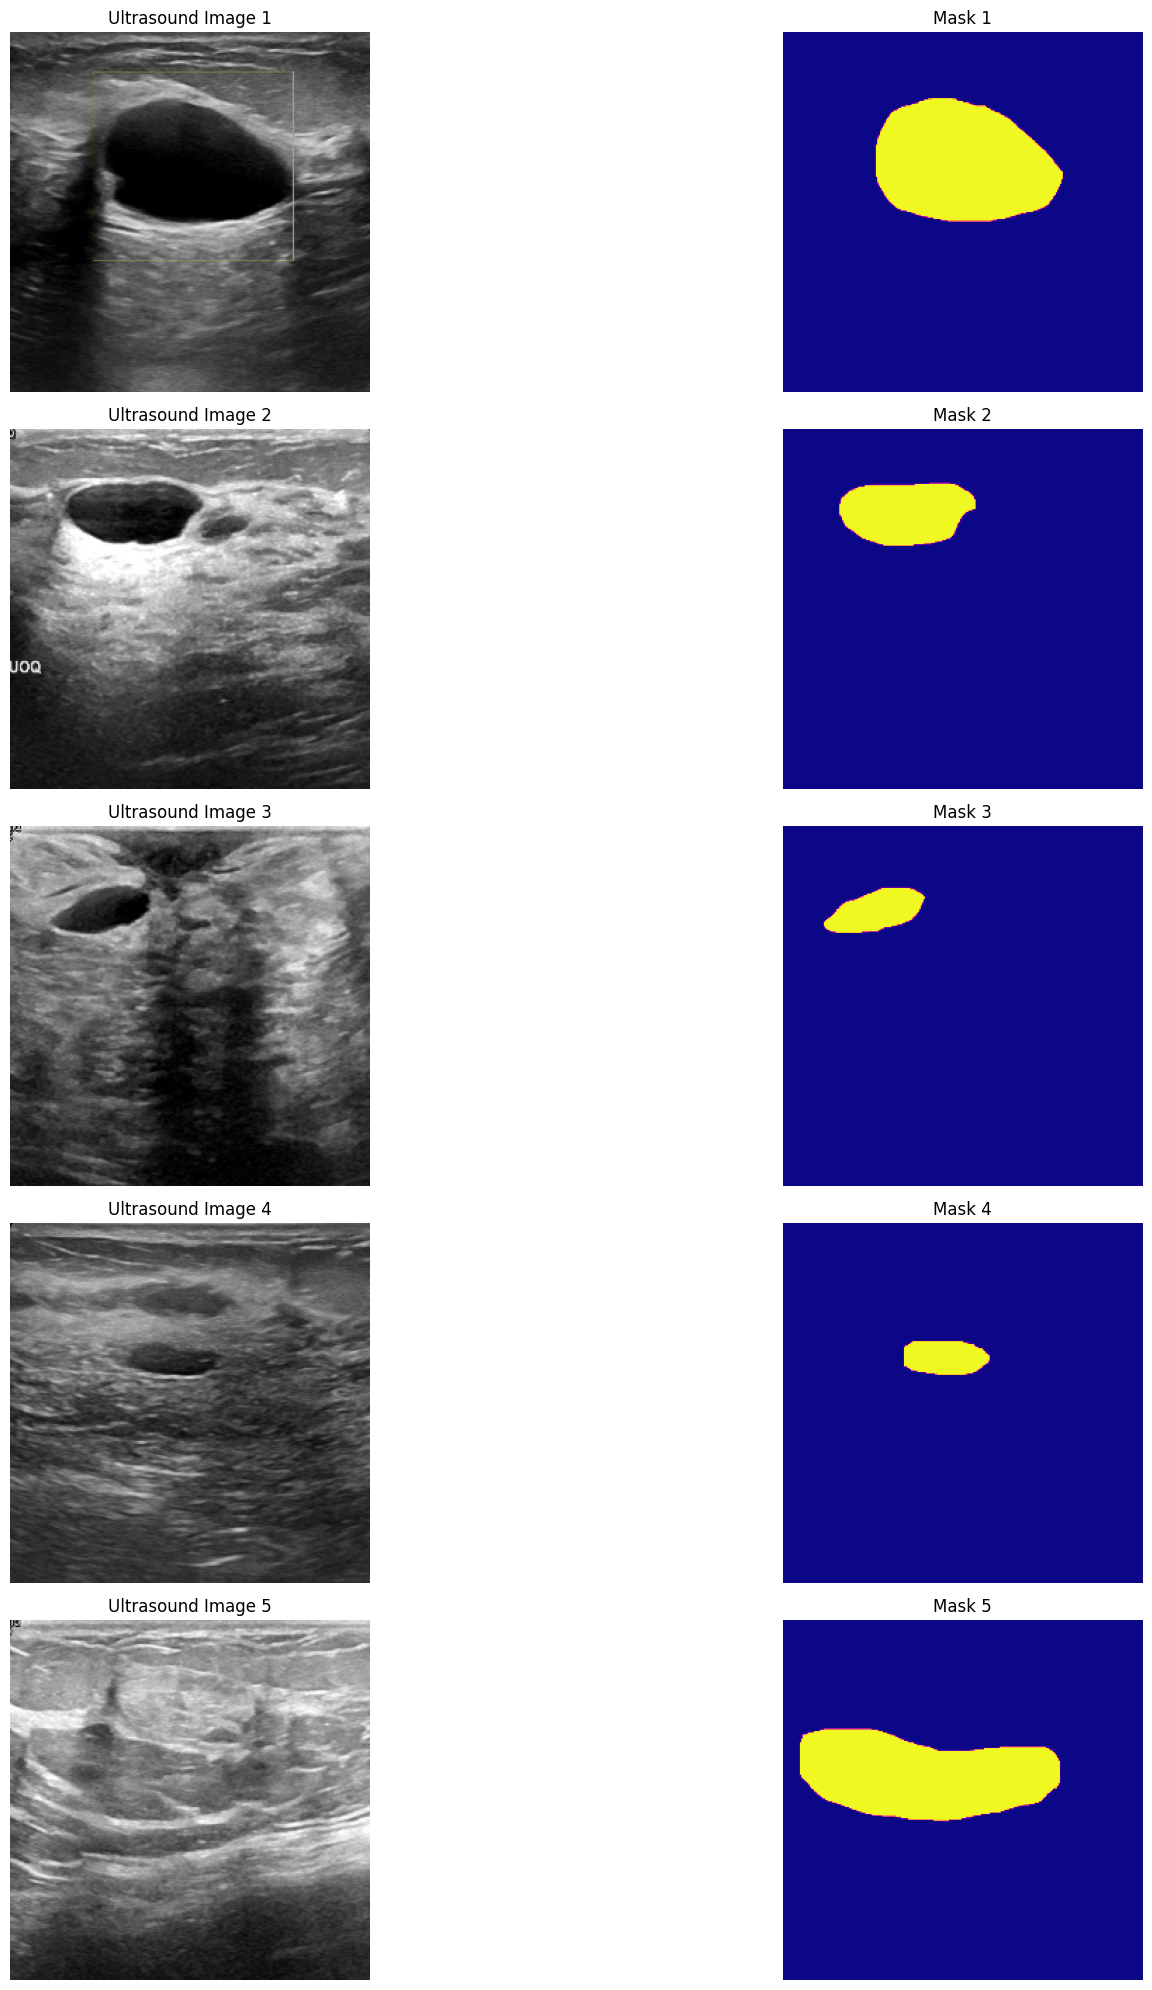

In [11]:
# ImageMaskVisualization
plt.figure(figsize=(20, 20))

for i in range(5):
    
    plt.subplot(5, 2, i * 2 + 1)
    plt.imshow(train_image_mask['images'][i])
    plt.title(f'Ultrasound Image {i+1}')
    plt.axis('off')

   
    plt.subplot(5, 2, i * 2 + 2)
    plt.imshow(train_image_mask['masks'][i], cmap='plasma')
    plt.title(f'Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Definition of one Convolution block of the U-Net architecture
def convolutionBlock(inputTensor, filterCount, kernelSize = 3):
    convolutionBlock = Conv2D(filters = filterCount, kernel_size = (kernelSize, kernelSize), kernel_initializer = 'he_normal', padding = 'same')(inputTensor)
    convolutionBlock = BatchNormalization()(convolutionBlock)
    convolutionBlock = Activation('relu')(convolutionBlock)
    
    convolutionBlock = Conv2D(filters = filterCount, kernel_size = (kernelSize, kernelSize), kernel_initializer = 'he_normal', padding = 'same')(convolutionBlock)
    convolutionBlock = BatchNormalization()(convolutionBlock)
    convolutionBlock = Activation('relu')(convolutionBlock)
    
    return convolutionBlock

# Definition of the entire U-Net architecture
def modelArchitecture(inputTensor, filterCount = 16, dropoutRate = 0.1):
    # Initialization of the encoder
    firstConvolution = convolutionBlock(inputTensor, filterCount)
    firstLayer = AveragePooling2D((2, 2))(firstConvolution)
    firstLayer = Dropout(dropoutRate)(firstLayer)
    
    secondConvolution = convolutionBlock(firstLayer, filterCount * 2)
    secondLayer = AveragePooling2D((2, 2))(secondConvolution)
    secondLayer = Dropout(dropoutRate)(secondLayer)
    
    thirdConvolution = convolutionBlock(secondLayer, filterCount * 4)
    thirdLayer = AveragePooling2D((2, 2))(thirdConvolution)
    thirdLayer = Dropout(dropoutRate)(thirdLayer)
    
    fourthConvolution = convolutionBlock(thirdLayer, filterCount * 8)
    fourthLayer = AveragePooling2D((2, 2))(fourthConvolution)
    fourthLayer = Dropout(dropoutRate)(fourthLayer)
    
    fifthConvolution = convolutionBlock(fourthLayer, filterCount * 16)
    
    # Initialization of the decoder
    firstDeconvolution = Conv2DTranspose(filterCount * 8, (3, 3), strides = (2, 2), padding = 'same')(fifthConvolution)
    sixthLayer = concatenate([firstDeconvolution, fourthConvolution])
    sixthLayer = Dropout(dropoutRate)(sixthLayer)
    sixthConvolution = convolutionBlock(sixthLayer, filterCount * 8)
    
    secondDeconvolution = Conv2DTranspose(filterCount * 4, (3, 3), strides = (2, 2), padding = 'same')(sixthConvolution)
    seventhLayer = concatenate([secondDeconvolution, thirdConvolution])
    seventhLayer = Dropout(dropoutRate)(seventhLayer)
    seventhConvolution = convolutionBlock(seventhLayer, filterCount * 4)
    
    thirdDeconvolution = Conv2DTranspose(filterCount * 2, (3, 3), strides = (2, 2), padding = 'same')(seventhConvolution)
    eighthLayer = concatenate([thirdDeconvolution, secondConvolution])
    eighthLayer = Dropout(dropoutRate)(eighthLayer)
    eighthConvolution = convolutionBlock(eighthLayer, filterCount * 2)
    
    fourthDeconvolution = Conv2DTranspose(filterCount, (3, 3), strides = (2, 2), padding = 'same')(eighthConvolution)
    ninthLayer = concatenate([fourthDeconvolution, firstConvolution])
    ninthLayer = Dropout(dropoutRate)(ninthLayer)
    ninthConvolution = convolutionBlock(ninthLayer, filterCount)
    
    outputLayer = Conv2D(1, (1, 1), activation = 'sigmoid')(ninthConvolution)
    segmentationModel = Model(inputs = [inputTensor], outputs = [outputLayer])
    
    return segmentationModel

In [13]:
# Initialization of the segmentation model
inputs = Input((256, 256, 3))

segmentationModel = modelArchitecture(inputs, dropoutRate = 0.1)
segmentationModel.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
segmentationModel.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ average_pooling2… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ average_pooling2

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [14]:
# SegmentationModelTraining
history = segmentationModel.fit(
    np.array(train_image_mask['images']), 
    np.array(train_image_mask['masks']),
    epochs=15,
    validation_data=(
        np.array(test_image_mask['images']), 
        np.array(test_image_mask['masks'])
    ),
    callbacks=[
        EarlyStopping(
            patience=15, 
            monitor='val_loss', 
            mode='min', 
            restore_best_weights=True, 
            verbose=1
        )
    ]
)

Epoch 1/15


c:\Users\black\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 134s 7s/step - accuracy: 0.6214 - loss: 0.6814 - val_accuracy: 0.4955 - val_loss: 5.5716
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 126s 7s/step - accuracy: 0.8963 - loss: 0.4333 - val_accuracy: 0.2698 - val_loss: 8.6582
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 130s 8s/step - accuracy: 0.9162 - loss: 0.3239 - val_accuracy: 0.2353 - val_loss: 8.9036
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 129s 8s/step - accuracy: 0.9226 - loss: 0.2874 - val_accuracy: 0.2481 - val_loss: 7.4025
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 133s 8s/step - accuracy: 0.9333 - loss: 0.2516 - val_accuracy: 0.3670 - val_loss: 5.9104
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 128s 8s/step - accuracy: 0.9365 - loss: 0.2342 - val_accuracy: 0.2653 - val_loss: 5.7597
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 131s 8s/step - accuracy: 0.9323 - loss: 0.2333 - val_accuracy: 0.4162 - val_loss: 2.9555
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 134s 8s/step - accuracy: 0.9409 - loss: 0.2096 - val_accuracy: 0.3849 - val_loss: 3.

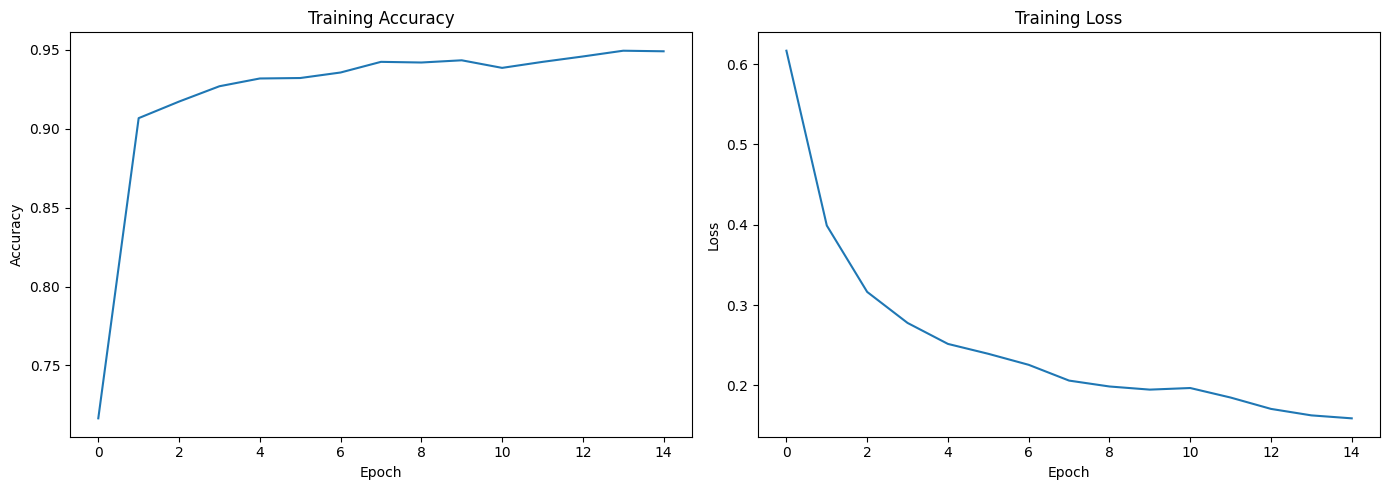

In [15]:
# Plotting of the training process
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(accuracy))

# Convert accuracy and loss to a DataFrame for easier plotting with Seaborn
history_df = pd.DataFrame({
    'Epoch': epochs,
    'Accuracy': accuracy,
    'Loss': loss
})

# Create subplots to place the plots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot training accuracy using Seaborn
sns.lineplot(data=history_df, x='Epoch', y='Accuracy', ax=axes[0])
axes[0].set_title('Training Accuracy')

# Plot training loss using Seaborn
sns.lineplot(data=history_df, x='Epoch', y='Loss', ax=axes[1])
axes[1].set_title('Training Loss')

# Display the plots
plt.tight_layout()
plt.show()

In [16]:
# SegmentationModelPrediction
testImages = test_image_mask['images']
testMasks = test_image_mask['masks']

predictions = segmentationModel.predict(np.array(testImages))
print(predictions.shape)

c:\Users\black\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
(130, 256, 256, 1)


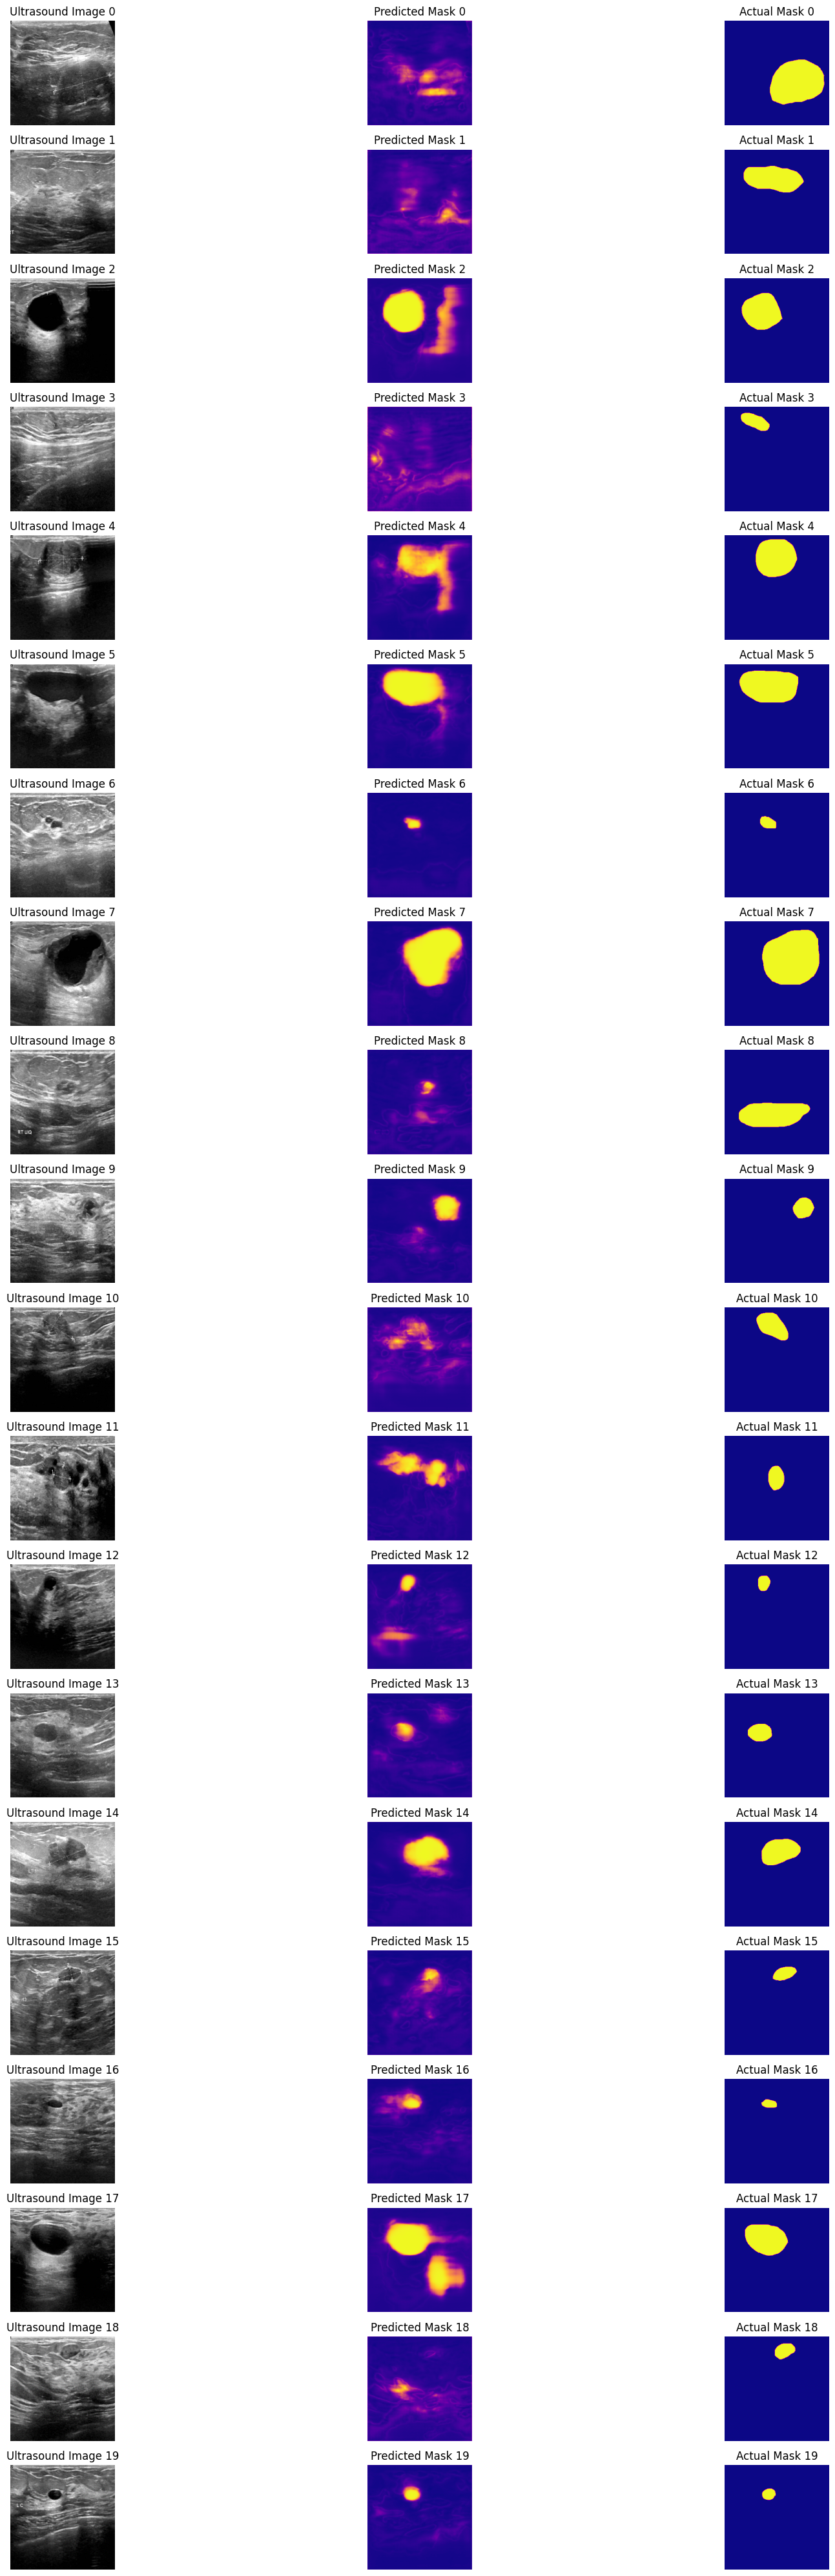

In [17]:
# Plotting of the predicted masks
import matplotlib.pyplot as plt

def plot_image_mask_comparisons(test_images, predictions, test_masks, indices, figsize=(20, 40)):
    """
    Plots ultrasound images, predicted masks, and actual masks side by side for comparison.

    Parameters:
        test_images (list/ndarray): List or array of test ultrasound images.
        predictions (list/ndarray): List or array of predicted masks.
        test_masks (list/ndarray): List or array of actual masks.
        indices (list): Indices of images to plot.
        figsize (tuple): Size of the figure.
    """
    num_samples = len(indices)
    plt.figure(figsize=figsize)

    for i, idx in enumerate(indices):
        # Plot Ultrasound Image
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(test_images[idx])
        plt.title(f'Ultrasound Image {idx}')
        plt.axis('off')

        # Plot Predicted Mask
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(predictions[idx], cmap='plasma')
        plt.title(f'Predicted Mask {idx}')
        plt.axis('off')

        # Plot Actual Mask
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(test_masks[idx], cmap='plasma')
        plt.title(f'Actual Mask {idx}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


indices_to_plot = list(range(20))  
plot_image_mask_comparisons(testImages, predictions, testMasks, indices_to_plot, figsize=(20, 40))

In [18]:
# SegmentationModelSaving
segmentationModel.save('Breast_Cancer_Segmentation.h5')

Evaluation Metrics:
Accuracy: 0.4979
Precision: 0.4975
Recall: 0.5072
F1 Score: 0.5023

Confusion Matrix:
[[2445 2559]
 [2462 2534]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.49      0.49      5004
           1       0.50      0.51      0.50      4996

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



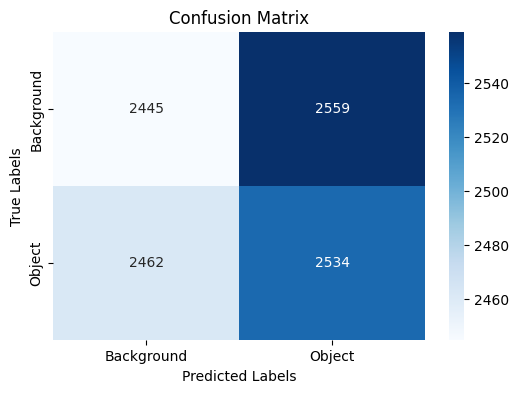

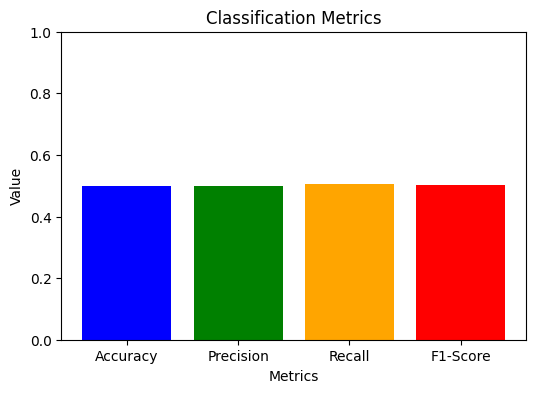

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report

def evaluate_segmentation_results(test_masks, predictions, threshold=0.5, class_labels=None):
    """
    Evaluates segmentation results using accuracy, F1 score, confusion matrix, and classification report.
    Includes confusion matrix visualization.

    Parameters:
        test_masks (ndarray): Ground truth masks (binary: 0 or 1).
        predictions (ndarray): Predicted masks (continuous values, e.g., probabilities).
        threshold (float): Threshold to binarize predicted masks.
        class_labels (list): Class labels for the confusion matrix (e.g., ['Background', 'Object']).

    Returns:
        dict: Dictionary of evaluation metrics.
    """
    # Flatten the arrays for comparison
    y_true = test_masks.flatten().astype(np.uint8)  # Ground truth in binary (0 or 1)
    y_pred = (predictions.flatten() > threshold).astype(np.uint8)  # Binarize predictions

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    # Print evaluation metrics
    print("Evaluation Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))  # Avoid undefined metrics

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels if class_labels else ['Class 0', 'Class 1'], 
                yticklabels=class_labels if class_labels else ['Class 0', 'Class 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}

# Example test masks and predictions (replace with actual data)
test_masks = np.random.randint(0, 2, size=(100, 100))  # Simulated binary ground truth
predictions = np.random.rand(100, 100) * 255.0         # Simulated continuous predictions

# Convert test masks to binary if necessary
test_masks_binary = (test_masks > 0.5).astype(np.uint8)  # Ensure ground truth is binary

# Scale predictions and convert to float
predictions_binary = (predictions / 255.0).astype(np.float32)

# Evaluate the segmentation results
metrics = evaluate_segmentation_results(test_masks_binary, predictions_binary, class_labels=['Background', 'Object'])

# Plotting classification metrics
plt.figure(figsize=(6, 4))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Classification Metrics')
plt.ylim(0, 1)
plt.show()
